# Model Development

<div style="background-color: rgb(33,150,243); padding: 15px; border-radius: 5px;">
This notebook covers the development and comparison of baseline and improved models for predicting hourly taxi demand. It involves training a baseline model, incorporating additional features, and testing various algorithms to improve accuracy. Each model’s performance is evaluated using metrics, with the aim of identifying the best model for demand forecasting.
</div>

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, learning_curve, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import random
import joblib
from xgboost import XGBRegressor

In [2]:
# setting seed for the whole notebook
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
def get_data(train_path, test_path):
    """
    Gets both train and test data 
    """
    train_df = pd.read_csv(train_path, parse_dates=['time'], index_col=0).sort_index()
    test_df = pd.read_csv(test_path, parse_dates=['time'], index_col=0).sort_index()
    return train_df, test_df

## Data Loading

In [4]:
train_df, test_df = get_data('../data/clean/imputed_train_with_temp_with_lags.csv', '../data/clean/imputed_test_with_temp_with_lags.csv')

In [5]:
# ewma values are nan because of the lags
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [6]:
train_df.head()

,passenger_count,trip_distance,trip_duration,PULocationID,DOLocationID,demand_count,hour,time_of_day,day_of_week,is_weekend,day_of_month,month,lag_3h,lag_6h,lag_12h,ewma_3h,ewma_6h,ewma_12h
time,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,1.0,13.435,19.0,60.0,168.0,2.0,0,Night,0,0,1,1,0.0,0.0,0.0,0.000,0.000000,0.000000
2023-01-01 01:00:00,1.0,0.900,8.0,168.0,247.0,3.0,1,Night,0,0,1,1,0.0,0.0,0.0,2.000,2.000000,2.000000
2023-01-01 02:00:00,1.0,1.925,5.5,136.0,127.0,2.0,2,Night,0,0,1,1,0.0,0.0,0.0,2.500,2.285714,2.153846
2023-01-01 03:00:00,1.0,2.770,22.0,51.0,69.0,6.0,3,Night,0,0,1,1,2.0,0.0,0.0,2.250,2.204082,2.130178
2023-01-01 04:00:00,1.0,3.875,15.0,60.0,69.0,2.0,4,Night,0,0,1,1,3.0,0.0,0.0,4.125,3.288630,2.725535


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7007 entries, 2023-01-01 00:00:00 to 2023-10-19 22:00:00
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  7007 non-null   float64
 1   trip_distance    7007 non-null   float64
 2   trip_duration    7007 non-null   float64
 3   PULocationID     7007 non-null   float64
 4   DOLocationID     7007 non-null   float64
 5   demand_count     7007 non-null   float64
 6   hour             7007 non-null   int64  
 7   time_of_day      7007 non-null   object 
 8   day_of_week      7007 non-null   int64  
 9   is_weekend       7007 non-null   int64  
 10  day_of_month     7007 non-null   int64  
 11  month            7007 non-null   int64  
 12  lag_3h           7007 non-null   float64
 13  lag_6h           7007 non-null   float64
 14  lag_12h          7007 non-null   float64
 15  ewma_3h          7007 non-null   float64
 16  ewma_6h          7007 no

## Data Preparation

#### Column types

In [8]:
# define column types for column transformer
config = {
    'y': 'demand_count',
    'cyclic_cols': ['hour', 'day_of_week', 'day_of_month', 'month'],
    'nominal_cols': ['time_of_day'],
    'numeric_cols': ['passenger_count', 'trip_distance', 'trip_duration', 
                     'is_weekend', 'lag_3h', 'lag_6h', 'lag_12h',
                     'ewma_3h', 'ewma_6h', 'ewma_12h'],
    'drop_cols': ['PULocationID', 'DOLocationID']
}

In [9]:
def sin_transform(x, period):
    """
    Sine transformation
    """
    return np.sin(x / period * 2 * np.pi)

In [10]:
def cos_transform(x, period):
    """
    Cosine transformation
    """
    return np.cos(x / period * 2 * np.pi)

In [11]:
def sin_transformer(period):
    """
    Creates sine function transformer
    """
    return FunctionTransformer(sin_transform, kw_args={'period': period})

In [12]:
def cos_transformer(period):
    """
    Creates cosine function transformer
    """
    return FunctionTransformer(cos_transform, kw_args={'period': period})

In [13]:
# column transformer for pipeline
column_transformer = make_column_transformer(
            (sin_transformer(12), ["month"]),
            (cos_transformer(12), ["month"]),
            (sin_transformer(31), ["day_of_month"]),
            (cos_transformer(31), ["day_of_month"]),
            (sin_transformer(7), ["day_of_week"]),
            (cos_transformer(7), ["day_of_week"]),
            (sin_transformer(24), ["hour"]),
            (cos_transformer(24), ["hour"]),
            (OneHotEncoder(handle_unknown='ignore'), config.get('nominal_cols')),
            (RobustScaler(), config.get('numeric_cols')),
            ('drop', config.get('drop_cols')),
            remainder='drop',
            force_int_remainder_cols=False
        )

#### Train and Test Data

In [14]:
X_train = train_df.drop(columns=config.get('y'))
y_train = train_df[config.get('y')]

X_test = test_df.drop(columns=config.get('y'))
y_test = test_df[config.get('y')]

In [15]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (7007, 17)
y_train shape: (7007,)
X_test shape: (1752, 17)
y_test shape: (1752,)


#### Helper Functions

In [16]:
def train_baseline_model(X, y, col_transformer, validation_split=0.2):
    """
    Builds DummyRegressor model
    """
    split_index = int(len(X) * (1 - validation_split))
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]
    
    baseline_pipeline = make_pipeline(col_transformer, DummyRegressor(strategy="mean"))
    baseline_pipeline.fit(X_train, y_train)
    
    y_pred = baseline_pipeline.predict(X_val)
    performance = {
        "Mean Squared Error": [mean_squared_error(y_val, y_pred)],
        "Mean Absolute Error": [mean_absolute_error(y_val, y_pred)],
        "R2 Score": [r2_score(y_val, y_pred)]
    }
    
    return baseline_pipeline, pd.DataFrame(performance), y_val, y_pred

In [17]:
def plot_predictions(y_test, y_preds):
    """
    Plots predicted vs actual values
    """
    test = pd.DataFrame(y_test)
    test['predictions'] = y_preds
    test = test.sort_index()
    test = test.rename(columns={'demand_count': 'actual'})
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test['actual'], color='C0', label='actual')
    plt.plot(test.index, test['predictions'], color='C1', label='predictions')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title('Actual vs Prediction')
    plt.legend()
    plt.show()

In [18]:
def train_linear_model(X, y, col_transformer, validation_split=0.2):
    """
    Builds a LinearRegressor model
    """
    split_index = int(len(X) * (1 - validation_split))
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]
    
    linear_pipeline = make_pipeline(col_transformer, LinearRegression())
    linear_pipeline.fit(X_train, y_train)
    
    y_pred = linear_pipeline.predict(X_val)
    performance = {
        "Mean Squared Error": [mean_squared_error(y_val, y_pred)],
        "Mean Absolute Error": [mean_absolute_error(y_val, y_pred)],
        "R2 Score": [r2_score(y_val, y_pred)]
    }
    
    return linear_pipeline, pd.DataFrame(performance), y_val, y_pred

In [19]:
def train_ridge_model(X, y, col_transformer, alpha=10, validation_split=0.2):
    """
    Builds a RidgeRegressor model
    """
    ridge_pipeline = make_pipeline(col_transformer, Ridge(alpha=alpha))

    split_index = int(len(X) * (1 - validation_split))
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

    ridge_pipeline.fit(X_train, y_train)
    
    y_pred = ridge_pipeline.predict(X_val)
    performance = {
        "Mean Squared Error": [mean_squared_error(y_val, y_pred)],
        "Mean Absolute Error": [mean_absolute_error(y_val, y_pred)],
        "R2 Score": [r2_score(y_val, y_pred)]
    }
    
    return ridge_pipeline, pd.DataFrame(performance), y_val, y_pred

In [20]:
def train_random_forest_model(X, y, col_transformer, validation_split=0.2):
    """
    Builds a RandomForestRegressor model
    """
    rf_pipeline = make_pipeline(col_transformer, RandomForestRegressor(n_estimators=100, max_depth=None, random_state=RANDOM_SEED))

    split_index = int(len(X) * (1 - validation_split))
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_val)

    performance = {
        "Mean Squared Error": [mean_squared_error(y_val, y_pred)],
        "Mean Absolute Error": [mean_absolute_error(y_val, y_pred)],
        "R2 Score": [r2_score(y_val, y_pred)]
    }
    
    return rf_pipeline, pd.DataFrame(performance), y_val, y_pred

In [21]:
def train_xgboost_model(X, y, col_transformer, validation_split=0.2):
    """
    Builds an XGBoostRegressor model
    """
    xgb_pipeline = make_pipeline(
        col_transformer,
        XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_SEED)
    )

    split_index = int(len(X) * (1 - validation_split))
    X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]
    
    xgb_pipeline.fit(X_train, y_train)
    
    y_pred = xgb_pipeline.predict(X_val)
    
    performance = {
        "Mean Squared Error": [mean_squared_error(y_val, y_pred)],
        "Mean Absolute Error": [mean_absolute_error(y_val, y_pred)],
        "R2 Score": [r2_score(y_val, y_pred)]
    }
    
    return xgb_pipeline, pd.DataFrame(performance), y_val, y_pred

In [22]:
def get_cyclic_feature_names():
    """
    Gets cyclic transformer feature names
    """
    cyclic_feature_names = [
    "sin_month", "cos_month", "sin_day_of_month", "cos_day_of_month",
    "sin_day_of_week", "cos_day_of_week", "sin_hour", "cos_hour"]
    return cyclic_feature_names

In [23]:
def plot_feature_importance(pipeline, config, step_name, return_features_df=False):
    """
    Plots feature importance for the model
    """
    feature_names = []
    
    if config.get('cyclic_cols'):
        feature_names.extend(get_cyclic_feature_names())
    
    if config.get('nominal_cols') and config.get('cyclic_cols'):
        feature_names.extend(
            list(
                pipeline.named_steps['columntransformer']
                .transformers_[8][1]
                .get_feature_names_out(config.get('nominal_cols'))
            )
        )
    elif config.get('nominal_cols'):
        feature_names.extend(
            list(
                pipeline.named_steps['columntransformer']
                .named_transformers_['onehotencoder']
                .get_feature_names_out(config.get('nominal_cols'))
            )
        )
    
    if config.get('numeric_cols'):
        feature_names.extend(config.get('numeric_cols'))
    
    model = pipeline.named_steps[step_name]
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    elif hasattr(model, 'feature_importances_'):
        coefficients = model.feature_importances_
    else:
        raise ValueError("The model does not have `coef_` or `feature_importances_` attributes.")
    
    if coefficients.ndim > 1:
        coefficients = coefficients.flatten()

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })

    feature_importance_df['Absolute Importance'] = feature_importance_df['Importance'].abs()
    feature_importance_df = feature_importance_df.sort_values(by='Absolute Importance', ascending=False)
    plt.figure(figsize=(10, 5))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    if return_features_df:
        return feature_importance_df.reset_index(drop=True)[['Feature', 'Importance']]

## Model Building

#### DummyRegressor - Baseline

In [24]:
dummy_pipeline, dummy_performance, dummy_val, dummy_preds = train_baseline_model(X_train, y_train, column_transformer)

In [25]:
dummy_performance

,Mean Squared Error,Mean Absolute Error,R2 Score
0,37.658653,4.714147,-0.02287


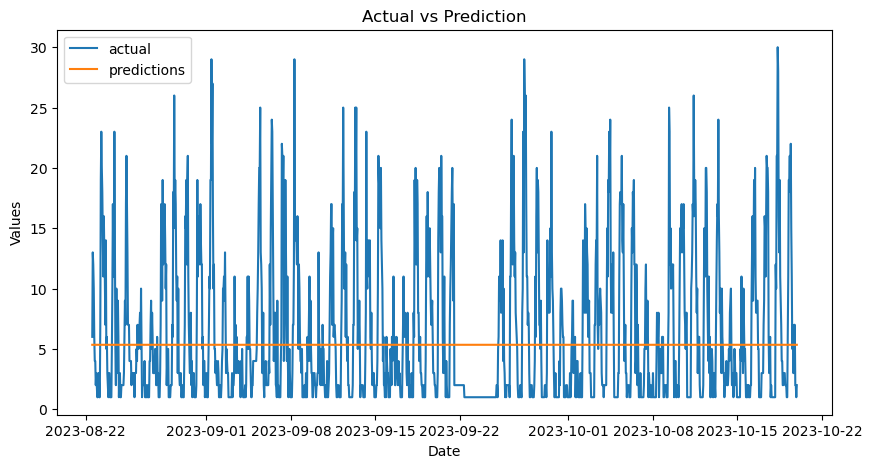

In [26]:
plot_predictions(dummy_val, dummy_preds)

#### Linear Regression

In [27]:
lr_pipeline, lr_performance, lr_val, lr_preds = train_linear_model(X_train, y_train, column_transformer)

In [28]:
lr_performance

,Mean Squared Error,Mean Absolute Error,R2 Score
0,10.270512,2.225682,0.721036


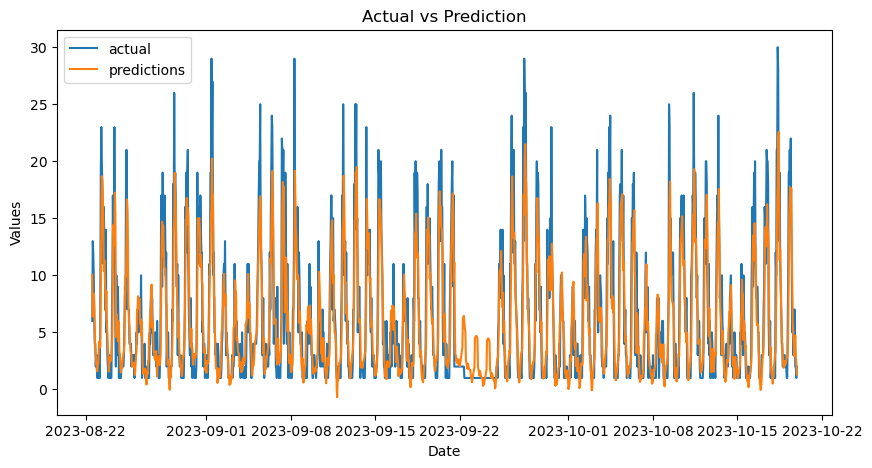

In [29]:
plot_predictions(lr_val, lr_preds)

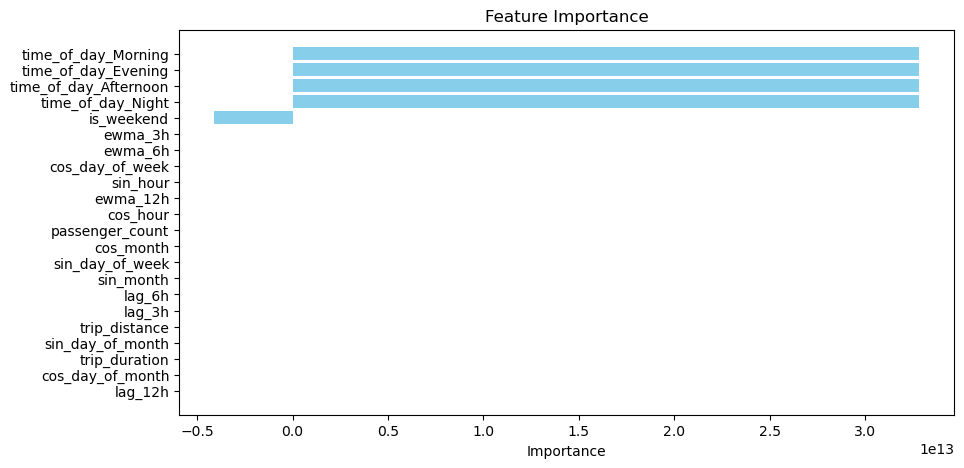

In [30]:
plot_feature_importance(lr_pipeline, config, 'linearregression')

#### Ridge LR

In [31]:
ridge_pipeline, ridge_performance, ridge_val, ridge_preds = train_ridge_model(X_train, y_train, column_transformer)

In [32]:
ridge_performance

,Mean Squared Error,Mean Absolute Error,R2 Score
0,10.397587,2.234172,0.717585


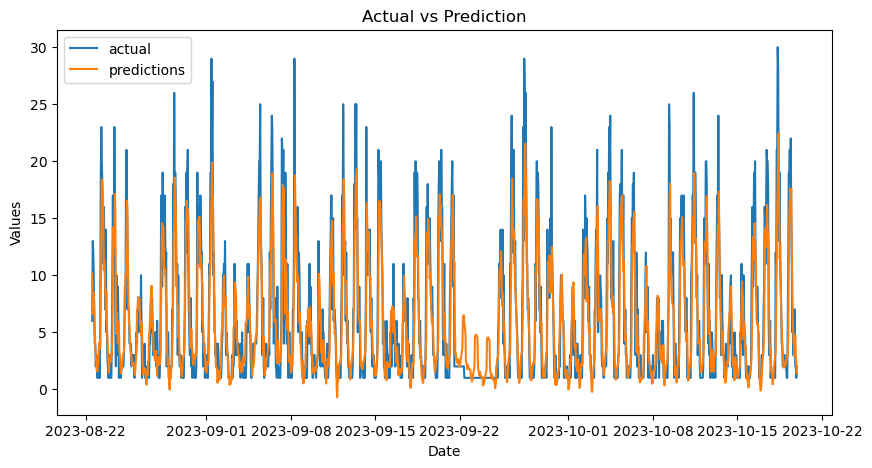

In [33]:
plot_predictions(ridge_val, ridge_preds)

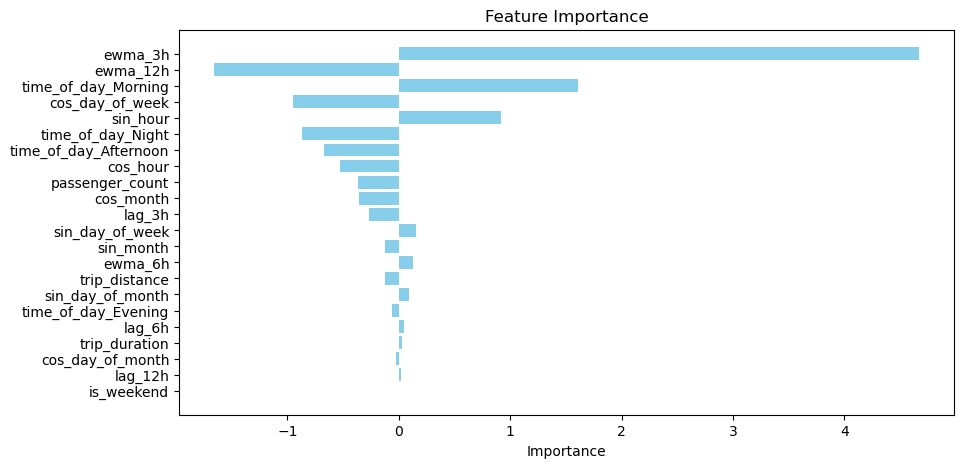

In [34]:
plot_feature_importance(ridge_pipeline, config, 'ridge')

#### Random Forest Regressor

In [35]:
rf_pipeline, rf_performance, rf_val, rf_preds = train_random_forest_model(X_train, y_train, column_transformer)

In [36]:
rf_performance

,Mean Squared Error,Mean Absolute Error,R2 Score
0,9.333205,2.133074,0.746495


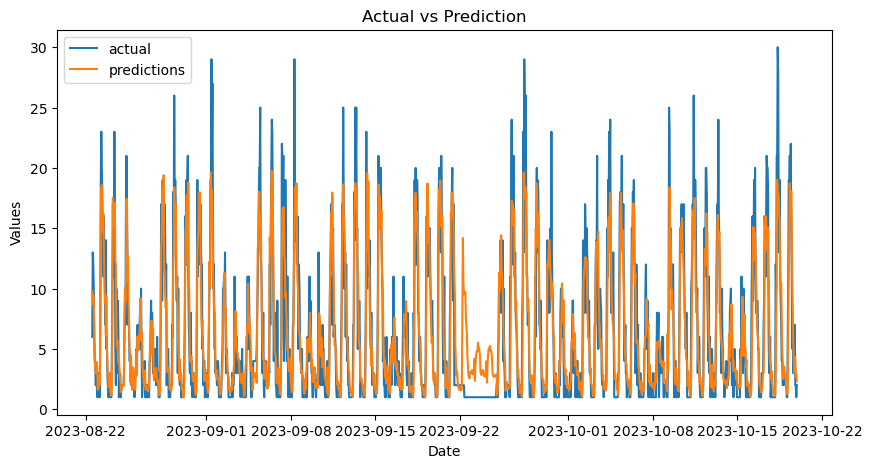

In [37]:
plot_predictions(rf_val, rf_preds)

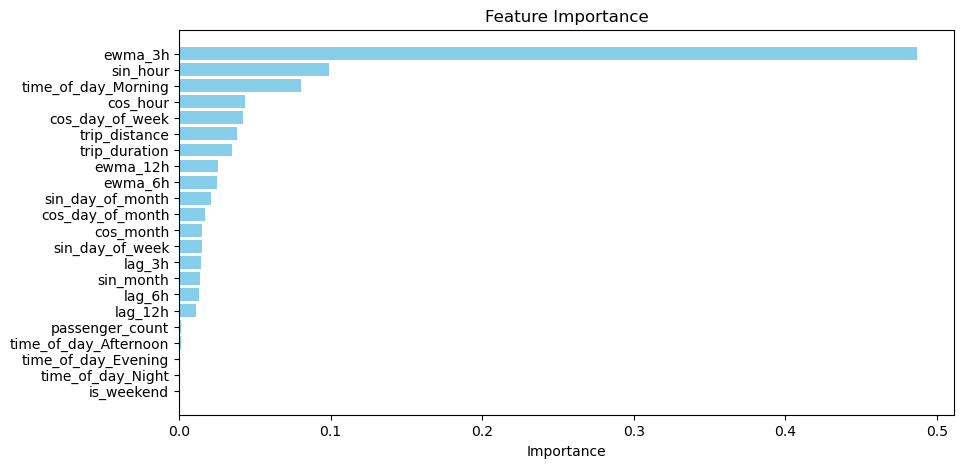

In [38]:
plot_feature_importance(rf_pipeline, config, 'randomforestregressor')

#### XGBoost

In [39]:
xgb_pipeline, xgb_performance, xgb_val, xgb_preds = train_xgboost_model(X_train, y_train, column_transformer)

In [40]:
xgb_performance

,Mean Squared Error,Mean Absolute Error,R2 Score
0,9.211053,2.126814,0.749813


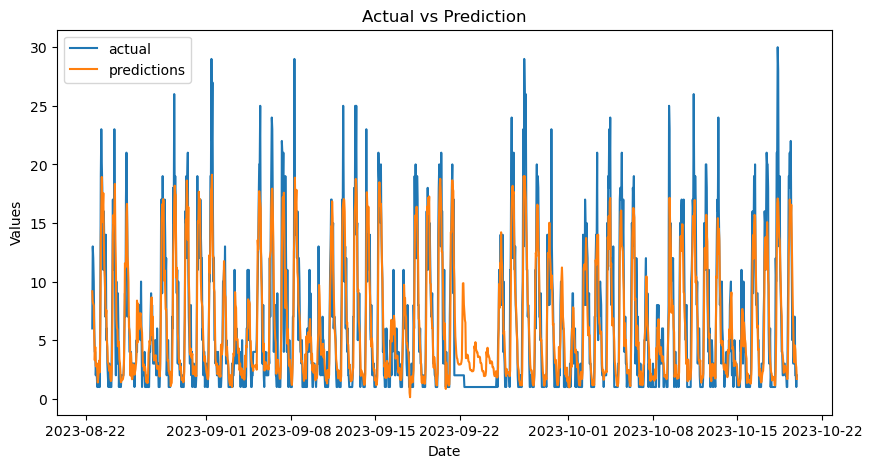

In [41]:
plot_predictions(xgb_val, xgb_preds)

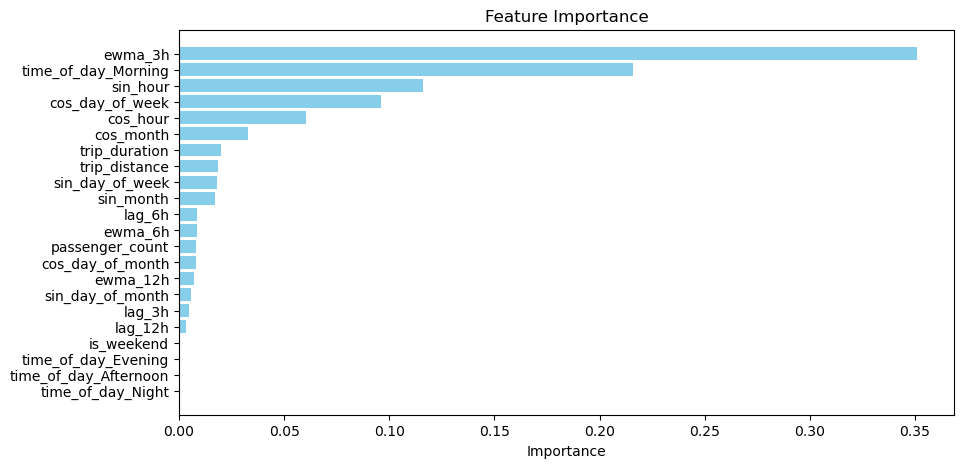

In [42]:
feature_importance_df = plot_feature_importance(xgb_pipeline, config, 'xgbregressor', return_features_df=True)

## Final Model

#### Keeping only significant features

In [43]:
feature_importance_df.head(12)

,Feature,Importance
0,ewma_3h,0.351055
1,time_of_day_Morning,0.216061
2,sin_hour,0.115906
3,cos_day_of_week,0.096191
4,cos_hour,0.060540
5,cos_month,0.032684
6,trip_duration,0.019822
7,trip_distance,0.018401
8,sin_day_of_week,0.018260
9,sin_month,0.016977


In [44]:
xgb_config = {'y': 'demand_count',
 'cyclic_cols': ['hour', 'day_of_week', 'day_of_month', 'month'],
 'nominal_cols': ['time_of_day'],
 'numeric_cols': ['ewma_3h', 'trip_duration', 'trip_distance', 'lag_6h', 'ewma_12h'],
 'drop_cols': ['PULocationID', 'DOLocationID']}

In [45]:
column_transformer = make_column_transformer(
            (sin_transformer(12), ["month"]),
            (cos_transformer(12), ["month"]),
            (sin_transformer(31), ["day_of_month"]),
            (cos_transformer(31), ["day_of_month"]),
            (sin_transformer(7), ["day_of_week"]),
            (cos_transformer(7), ["day_of_week"]),
            (sin_transformer(24), ["hour"]),
            (cos_transformer(24), ["hour"]),
            (OneHotEncoder(handle_unknown='ignore'), xgb_config.get('nominal_cols')),
            (RobustScaler(), xgb_config.get('numeric_cols')),
            ('drop', xgb_config.get('drop_cols')),
            remainder='drop',
            force_int_remainder_cols=False
        )

#### Hyperparameter Tuning of Best Model

In [46]:
def fine_tune_xgboost(X, y, col_transformer, param_grid, n_splits=5):
    """
    Performs hyperparameter tuning for XGBoostRegressor model
    """
    xgb_pipeline = make_pipeline(
        col_transformer,
        XGBRegressor(objective='reg:squarederror', random_state=42)
    )

    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    grid_search = GridSearchCV(
        xgb_pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_

    results_df = pd.DataFrame(grid_search.cv_results_)[[
        'params', 'mean_test_score', 'std_test_score', 'rank_test_score'
    ]].sort_values(by='rank_test_score')
    results_df['mean_test_score'] = -results_df['mean_test_score']
    
    return best_pipeline, best_params, grid_search, results_df

In [47]:
def evaluate_model(model, X_test, y_test):
    """
    Calculates score for model
    """
    y_pred = model.predict(X_test)
    performance = {
        "Mean Squared Error": [mean_squared_error(y_test, y_pred)],
        "Mean Absolute Error": [mean_absolute_error(y_test, y_pred)],
        "R2 Score": [r2_score(y_test, y_pred)]
    }
    return pd.DataFrame(performance), y_pred

In [48]:
# parameters for xgboost hyperparameter tuning via gridsearch
param_grid = {
            'xgbregressor__n_estimators': [50, 100, 200],
            'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
            'xgbregressor__max_depth': [3, 5, 7],
            'xgbregressor__subsample': [0.8, 1.0],
            'xgbregressor__colsample_bytree': [0.8, 1.0]
        }

#### XGBoost fine tuned

In [49]:
fine_tuned_model, best_params, grid_search, all_results_df = fine_tune_xgboost(X_train, y_train, column_transformer, param_grid)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [50]:
all_results_df.head()

,params,mean_test_score,std_test_score,rank_test_score
18,"{'xgbregressor__colsample_bytree': 0.8, 'xgbre...",8.248789,1.527572,1
24,"{'xgbregressor__colsample_bytree': 0.8, 'xgbre...",8.263036,1.634177,2
25,"{'xgbregressor__colsample_bytree': 0.8, 'xgbre...",8.267606,1.544821,3
73,"{'xgbregressor__colsample_bytree': 1.0, 'xgbre...",8.275033,1.511461,4
19,"{'xgbregressor__colsample_bytree': 0.8, 'xgbre...",8.282040,1.543482,5


In [51]:
best_params

{'xgbregressor__colsample_bytree': 0.8,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 3,
 'xgbregressor__n_estimators': 50,
 'xgbregressor__subsample': 0.8}

#### Applying model on the test set

In [52]:
test_output, test_preds = evaluate_model(fine_tuned_model, X_test, y_test)

In [53]:
test_output

,Mean Squared Error,Mean Absolute Error,R2 Score
0,11.509999,2.283002,0.669625


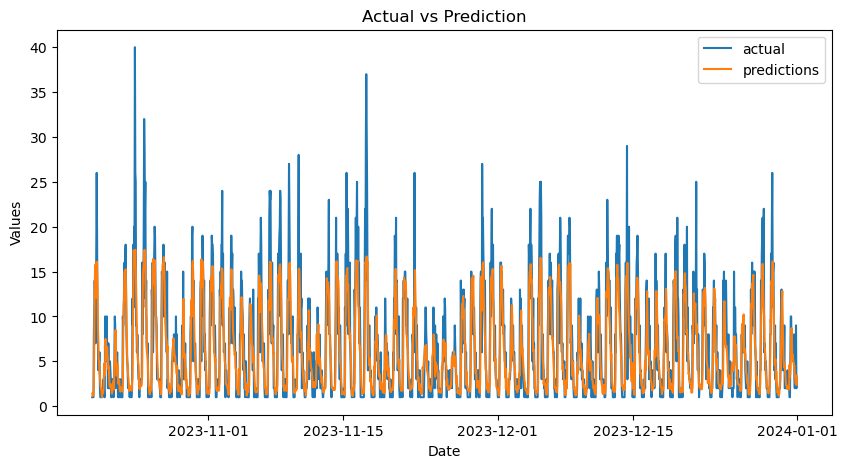

In [54]:
plot_predictions(y_test, test_preds)

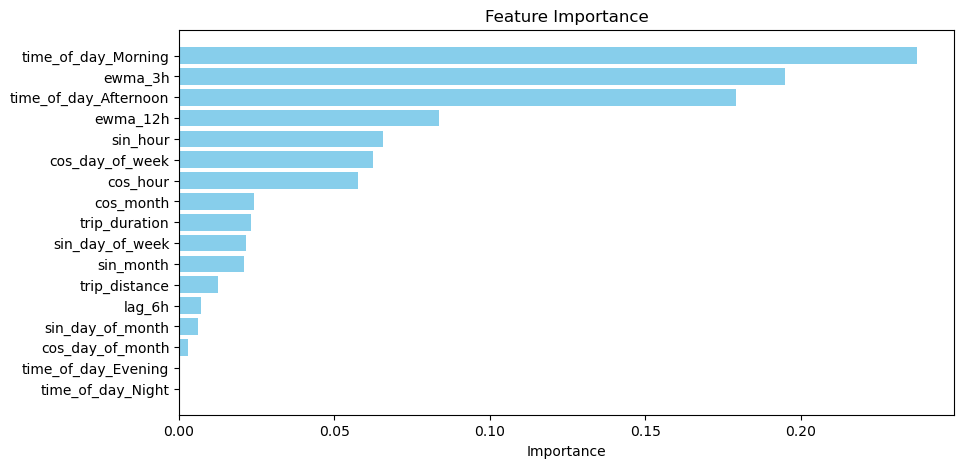

In [59]:
features = plot_feature_importance(fine_tuned_model, xgb_config, 'xgbregressor', return_features_df=True)

In [60]:
features

,Feature,Importance
0,time_of_day_Morning,0.237554
1,ewma_3h,0.195070
2,time_of_day_Afternoon,0.179381
3,ewma_12h,0.083688
4,sin_hour,0.065503
5,cos_day_of_week,0.062319
6,cos_hour,0.057589
7,cos_month,0.024029
8,trip_duration,0.023300
9,sin_day_of_week,0.021515


## Exporting Model

In [56]:
def save_model(model, filename="../models/best_model.joblib"):
    """
    Saves a model as joblib
    """
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

In [57]:
fine_tuned_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function sin_transform at 0x1453a1750>,
                                                                      kw_args={'period': 12}),
                                                  ['month']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function cos_transform at 0x1453a1bd0>,
                                                                      kw_args={'period': 12}),
                                                  ['month']),
                                                 ('functi...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [58]:
save_model(fine_tuned_model)

Model saved as ../models/best_model.joblib
